In [1]:
# drive.mount('/content/drive')
# from google.colab import drive
from math import log
from nltk.cluster import KMeansClusterer,cosine_distance
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from PIL import Image
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
import nltk, re, string
import numpy as np
import os
import pandas as pd
import seaborn as sns
import string


In [2]:
# nltk.download()

In [3]:


main_path = "C:/Users/Administrator/OneDrive - stevens.edu/Stevens BIA/660/BIA 660 Project_AI_jobs/"
arg_path_txt = main_path+"indeed_JD代码及结果/JDs/"
arg_k_42_result_save = main_path+"Kmean_42_result/"

#####################  EDA
# test - with small dataset
# len_test = 10700-8000 # how many JDs need to input
len_test = 10700
# s_len_test = 314074-300000 # how many sentence data need to input
s_len_test = 314074


##################### Preprocessing 
arg_max_dup = 500 # delete sentences with duplicate count > 500
arg_min_len = 10 # delete sentences with min length < 10
# arg_max_len = 4000 
arg_max_len = 600


# K-means
arg_k=42

# TF-IDF
arg_min_df = 10
version = 3 


# Evaluation from k_begin to k_end
k_begin = 30
k_end = 46 
e_test = 20000






# 1. Import the scraping data

In [4]:
# Every JD as a unit.
path_txt = arg_path_txt
files= os.listdir(path_txt) 

s = []  # separate sentence
jd = []  #  separate JD 
for file in files: 
     if not os.path.isdir(file): 
        f1 = open(path_txt+"/"+file,"r", encoding = 'utf8') 
        s.extend(list(f1)) #save separate sentence into list
        f1.close()
        f2 = open(path_txt+"/"+file,"r", encoding = 'utf8') 
        tmp = f2.read().split("\n\n\n") 
        f2.close()
        jd.extend(tmp) #save separate JD into list 

print("length of all jds:",len(jd), "\nlength of unique jds:",len(set(jd)))
print("length of all sentences:",len(s), "\nlength of unique sentences:",len(set(s)))

length of all jds: 10707 
length of unique jds: 3917
length of all sentences: 314074 
length of unique sentences: 56484


# 2. EDA 
- what kind of data are replicated?
    - What is the distribution of JDs length?
    - What is the distribution of sentence?
    - What is the distribution of words?
- Visualization

## 2.1 JD

### 2.1.1 JD len

In [5]:
jd = jd[0:len_test]

jdl = [len(x) for x in jd]
jd_len = pd.DataFrame([jd,jdl]).T
col_name = ['text','cnt']
jd_len.columns=col_name

jd_len.head(3)
# jd_len['cnt'].astype(int).describe()

,text,cnt
0,TEAMMATE WANTED:\nWe are currently seeking an ...,2107
1,"Cityscapes Inc., the largest interior and exte...",1376
2,Assist Veterinarians in patient care and medic...,1168


## 2.1.2 len of JDs distribution

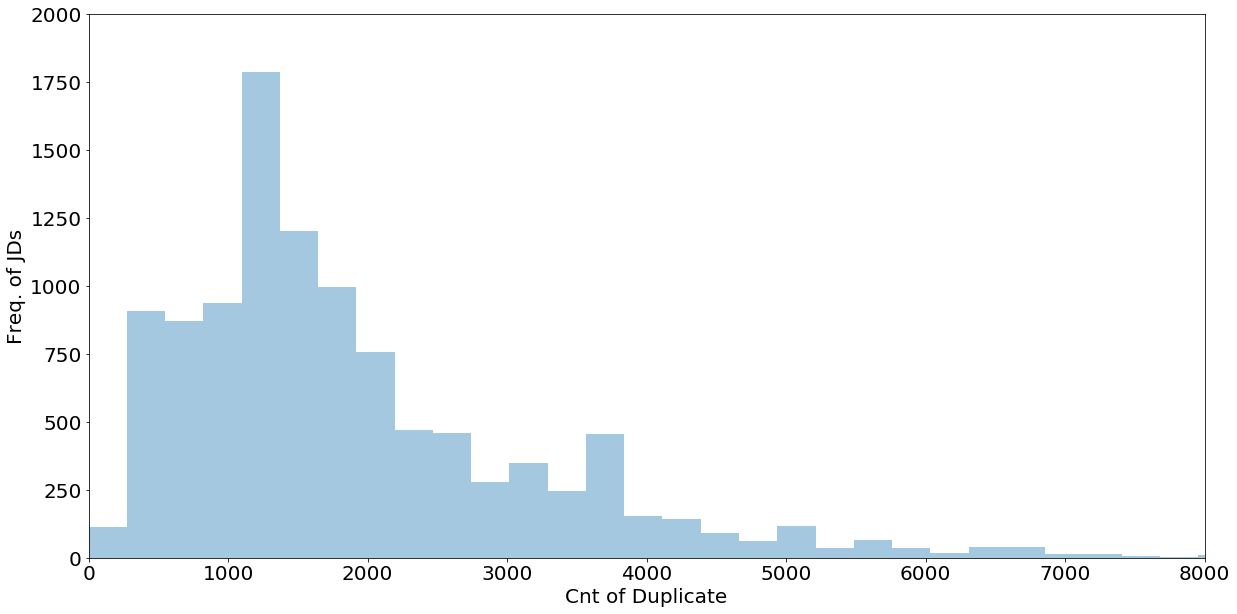

max_len 822815


,text,cnt
801,"\nOverview\nThe Welcome Team Member position provides a welcoming and safe environment for the members through high levels of customer service. The Welcome Team member’s interaction with members directly contributes to member retention and satisfaction.\nThe Welcome Team role achieves success through embodying our core competencies (Create the TSI Environment, Build a High Performing Team, Achieve Measurable Results). Create the TSI Environment Models the core attributes of a successful employee with the utmost integrity, lives the mission and empowers others to do the same; focused on building meaningful relationships with members, their kids and team members. Responsibilities include:\nModeling and promoting the Clubhouse Rules.\nAdhering to all TSI policies and procedures including, but not limited to timeliness, codes of conduct, uniforms and timekeeping. Setting expectations around the same for team members. Setting expectations for team members. Build a High Performing Team Actively facilitates self and team member development; constantly seeking new ways to build skills and competency; elevates the brand experience. Responsibilities include:\nEfficiently check in and handle routine member service tasks using the club systems such as (but not limited to) resetting passwords, updating credit cards and managing class reservations.\nNavigating basic questions about membership, services and billing inquiries.\nProviding a clean and organized Welcome Area at all times.\nBeing proficient in the use of MoSo, Club Networks, KRONOS, and any other computer program required to meet the business needs of the customer and TSI.\nProviding high levels of customer service and attentiveness to member needs.\nBeing responsive to member feedback and complaints and escalating issues to club mgmt team as necessary.\nPerforming point of sale transactions.\nQuickly addressing any maintenance or equipment issues that are visible to members.\nAssisting GM in administrative tasks including (but not limited to) billing calls and confirming appointments. Achieve Measurable Results Meets and exceeds company goals and metrics surrounding employees and members; never satisfied with the status quo. Responsibilities include: Proactively seeking ways to positively influence the member experience and address member feedback.\nEffectively communicating new promotions and services at point of contact, so that the member gets the most out of their gym membership. Requirements\nRequired Skills and Experience 1-2 years prior club experience in a member-facing role and/or prior customer service role.\nExperience working with computer systems and navigating through work screens.\nPhysical demands include ability to walk through all areas of clubs, climbing stairs (where applicable), standing behind the front desk, and bending and lifting (e.g., picking up towels, restacking of weights, moving of equipment as necessary).\nCPR/AED required within 30 days of hire for all opening &...",822815


In [6]:
def len_plot(data,xlim, ylim):
    
    plt.figure(figsize=(20,10))
    sns.distplot(list(data['cnt']),hist= True,kde = False,bins=3000,color=None)
#     sns.distplot(data['cnt'],hist= True,kde = False,bins=3000,color=None)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.xlabel('Cnt of Duplicate',color='k', size=20)
    plt.ylabel('Freq. of JDs',color='k', size=20)
    plt.tick_params(labelsize=20,labelcolor = 'k', colors='k')
    plt.show()
    data.describe()
    print("max_len",max(data['cnt']))
    L = data[data['cnt']==max(data['cnt'])]
    return L

pd.set_option('max_colwidth',3000)
Long = len_plot(jd_len,8000, 2000)
Long

## 2.2 Sentence


### 2.2.1 length of Sentence distribution

In [7]:
# s_set = set(s) 
# s_freq = [{s.count(x),x} for x in s_set] # duplicated count # extremely slow!

s = s[0:s_len_test]
def s_cnt(s):# input sentence - list
    s_l = [len(x) for x in s] # sentence length 
    s_len = pd.DataFrame([s,s_l]).T
    col_name = ['text','cnt']
    s_len.columns=col_name
    s_len['cnt'] = s_len['cnt'].astype(int)
    print(s_len['cnt'].describe())
    return s_len
s_len = s_cnt(s)

count    314074.000000
mean         67.920452
std         129.083987
min           1.000000
25%          16.000000
50%          34.000000
75%          71.000000
max       12339.000000
Name: cnt, dtype: float64


In [8]:
s_len[1:10]

,text,cnt
1,We are currently seeking an experienced medical receptionist/office manager for our Outpatient chiropractic and physical therapy clinics located in Boston's Back Bay. We are looking for a full time receptionist to join our fast growing team. We are expanding our chiropractic and physical therapy practice located in Invictus CrossFit gym in Boston.\n,350
2,"We are looking for someone who is a superstar, who is physically active and enjoys the Health Club/CrossFit setting. Our offices are in higher end CrossFit Gyms. They are not your typical office settings and require the right person for the position.\n",251
3,Job Duties:\n,12
4,Greet patients\n,15
5,Answer phones\n,14
6,Verify current personal and financial information\n,50
7,Book appointments\n,18
8,Verify insurance benefits\n,26
9,Collect payments\n,17


### 2.2.2 duplicated Sentence distribution

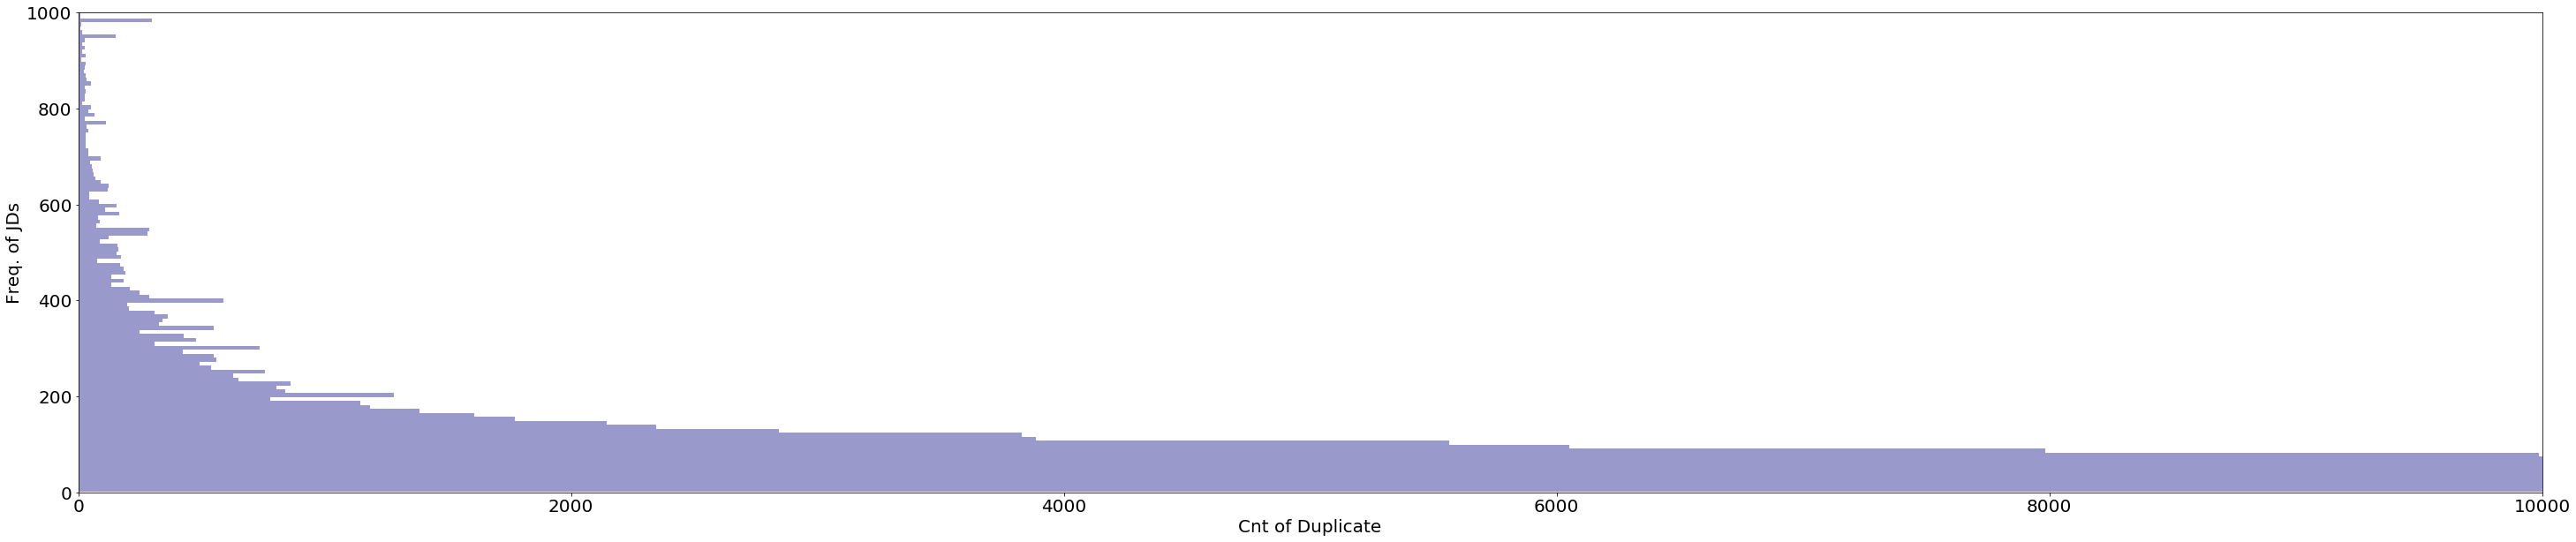

max_len 12339


,text,cnt
300652,"Supplemental Life and AD&D Insurance Our Company is an equal employment opportunity employer. The Company's policy is not to discriminate against any applicant or employee based on race, color, sex, sexual orientation, gender identity, genetic information, religion, national origin, age, disability, veteran status, or any other basis protected by applicable federal, state, or local laws. The Company also prohibits harassment of applicants or employees based on any of these protected categories. It is also the Company's policy to comply with all applicable state and federal laws respecting consideration of unemployment status in making hiring decisions. ______________________________________________________________________________ When you apply for this job, you will be asked to answer questions regarding your criminal background. Answering “Yes” to the criminal background questions will not automatically bar you from employment. A criminal background check will be conducted following any conditional offer of employment. Only those crimes which are substantially related to the position you are seeking will be considered. Please note that for certain contractors with whom we do business, based on the nature of their operation, the type of offense and related factors may affect your assignment to that contractor. Factors that will be taken into account include: (1) The facts or circumstances surrounding the offense or conduct; (2) the number of offenses for which you were convicted or plea was entered; (3) your age at the time of conviction or plea, or release from prison; (4) any evidence that you performed the same or similar type of work, post conviction/plea, with the same or different employers, with no known incidents of criminal conduct; (5) the length and consistency of employment history before and after the offense or conduct; (6) any rehabilitation efforts, e.g. education/training; (7) any employment or character references and any other information regarding your fitness for the particular position; and/or (8) whether you are bonded under a federal, state, or local bonding program. For applicants residing in and/or applying for a position in a state or locality listed below, please review the specific directions below before submitting your application. CALIFORNIA APPLICANTS: Choose the answer: ""I live in and/or am applying for a job in a state that does not require an answer at this time."" YOU WILL BE ASKED TO ANSWER THE CRIMINAL HISTORY QUESTIONS WHEN YOU HAVE RECEIVED A CONDITIONAL OFFER OF EMPLOYMENT. CALIFORNIA APPLICANTS: Do not identify any misdemeanor conviction for which probation has been successfully completed or otherwise discharged and the case has been dismissed by a court. Also, do not identify marijuana related convictions entered by the court more than 2 years ago that involve: unlawful possession of marijuana; transportation or giving away of up to 28.5 grams of marijuana, other than concentrated cannabis, or the o...",12339


In [9]:
# pd.set_option('max_colwidth',3000)
def len_plot_T(data,xlim, ylim):
    
    plt.figure(figsize=(50,10))
    sns.distplot(list(data['cnt']),hist= True,kde = False,bins=1500,color='navy',vertical=True)
#     sns.distplot(data['cnt'],hist= True,kde = False,bins=3000,color=None)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.xlabel('Cnt of Duplicate',color='k', size=20)
    plt.ylabel('Freq. of JDs',color='k', size=20)
    plt.tick_params(labelsize=20,labelcolor = 'k', colors='k')
    plt.show()
    data.describe()
    print("max_len",max(data['cnt']))
    L = data[data['cnt']==max(data['cnt'])]
    return L

Long = len_plot_T(s_len,10000, 1000)   
Long

In [10]:
s_len.sort_values('cnt',ascending = False).head(2)
# s_len.sort_values('cnt',ascending = False).tail(2)
# max(s_len['cnt'])

,text,cnt
300652,"Supplemental Life and AD&D Insurance Our Company is an equal employment opportunity employer. The Company's policy is not to discriminate against any applicant or employee based on race, color, sex, sexual orientation, gender identity, genetic information, religion, national origin, age, disability, veteran status, or any other basis protected by applicable federal, state, or local laws. The Company also prohibits harassment of applicants or employees based on any of these protected categories. It is also the Company's policy to comply with all applicable state and federal laws respecting consideration of unemployment status in making hiring decisions. ______________________________________________________________________________ When you apply for this job, you will be asked to answer questions regarding your criminal background. Answering “Yes” to the criminal background questions will not automatically bar you from employment. A criminal background check will be conducted following any conditional offer of employment. Only those crimes which are substantially related to the position you are seeking will be considered. Please note that for certain contractors with whom we do business, based on the nature of their operation, the type of offense and related factors may affect your assignment to that contractor. Factors that will be taken into account include: (1) The facts or circumstances surrounding the offense or conduct; (2) the number of offenses for which you were convicted or plea was entered; (3) your age at the time of conviction or plea, or release from prison; (4) any evidence that you performed the same or similar type of work, post conviction/plea, with the same or different employers, with no known incidents of criminal conduct; (5) the length and consistency of employment history before and after the offense or conduct; (6) any rehabilitation efforts, e.g. education/training; (7) any employment or character references and any other information regarding your fitness for the particular position; and/or (8) whether you are bonded under a federal, state, or local bonding program. For applicants residing in and/or applying for a position in a state or locality listed below, please review the specific directions below before submitting your application. CALIFORNIA APPLICANTS: Choose the answer: ""I live in and/or am applying for a job in a state that does not require an answer at this time."" YOU WILL BE ASKED TO ANSWER THE CRIMINAL HISTORY QUESTIONS WHEN YOU HAVE RECEIVED A CONDITIONAL OFFER OF EMPLOYMENT. CALIFORNIA APPLICANTS: Do not identify any misdemeanor conviction for which probation has been successfully completed or otherwise discharged and the case has been dismissed by a court. Also, do not identify marijuana related convictions entered by the court more than 2 years ago that involve: unlawful possession of marijuana; transportation or giving away of up to 28.5 grams of marijuana, other than concentrated cannabis, or the o...",12339
268031,"Support and Coordination of Operations Maintains administrator/director schedules. Identifies scheduling conflicts and resolves proactively. Provides high-level meeting support for division leaders and their direct reports, including room scheduling, agenda planning, catering coordination, AV setup, and taking minutes. Provides project and initiative support for leaders and their direct reports. Coordinates and prioritizes workload to meet timelines and deadlines. Gathers, analyzes and presents data such as process improvement initiatives, dashboards, staff and patient rounding statistics, stoplight summaries, variance reports, quality improvement measures and case reviews. Submits assigned projects, statistics, reports and/or other paperwork according to agreed-upon timelines. Establishes and maintains reasonable par levels and organization for office supplies. Maintains a well-organized and stocked desk area, which facilitates efficient department o

### 2.2.3 check the duplicate of sentence - prepared for preprocessing
- The result shows that most of category words should be deleted
- Should not deleted sentence with short words because most of requirements are also short
- Explore the relationship between duplicated_cnt and length of sentence

In [11]:
#  s_len.sort_values("len")
def dup_cnt(s_len):
    SS=s_len.loc[:,:].groupby('text').count().rename(columns={"cnt":"duplicated_cnt"}) # count
    SS.reset_index(inplace=True) # add index
    duplic = SS  # descending
#     duplic = SS.sort_values("duplicated_cnt",ascending = False)
    duplic['len'] = [len(x) for x in duplic['text']]  # add len to the column
    return duplic

duplic = dup_cnt(s_len)
duplic.sort_values("duplicated_cnt",ascending = False).head(20)
# duplic.sort_values('duplicated_cnt',ascending = True).head(10)

,text,duplicated_cnt,len
0,\n,21395,1
26283,Job Type: Full-time\n,5558,20
20220,Experience:\n,5145,12
52203,Work Location:\n,4093,15
33556,One location\n,3847,13
11656,Benefits:\n,3144,10
17800,Education:\n,2785,11
35259,Paid time off\n,2449,14
23801,Health insurance\n,2410,17
43589,Schedule:\n,1784,10


# 3. Textual data preprocessing


## 3.1 short length data check: should be deleted

In [12]:
# duplic.sort_values('len', ascending=True).iloc[0:100]
duplic[duplic['len']<=10] 

,text,duplicated_cnt,len
0,\n,21395,1
12,#CF\n,2,4
13,#GD #IND1\n,11,10
16,#LI-DS1\n,3,8
18,#LI-KD2\n,2,8
...,...,...,...
56386,職務経験:\n,2,6
56387,言語:\n,2,4
56388,語言與技能要求：\n,1,9
56390,\n,12,2


## 3.2 highly duplicated data check

In [13]:
duplic[duplic['duplicated_cnt']>500].sort_values("duplicated_cnt",ascending = False)
# duplic[duplic['duplicated_cnt']<2].count() # 24735

,text,duplicated_cnt,len
0,\n,21395,1
26283,Job Type: Full-time\n,5558,20
20220,Experience:\n,5145,12
52203,Work Location:\n,4093,15
33556,One location\n,3847,13
11656,Benefits:\n,3144,10
17800,Education:\n,2785,11
35259,Paid time off\n,2449,14
23801,Health insurance\n,2410,17
43589,Schedule:\n,1784,10


In [14]:
duplic.describe()

,duplicated_cnt,len
count,56484.000000,56484.000000
mean,5.560406,110.526043
std,105.990103,185.165053
min,1.000000,1.000000
25%,1.000000,38.000000
50%,2.000000,63.000000
75%,3.000000,109.000000
max,21395.000000,12339.000000


## 3.3 processing outliers and visualization 

In [15]:
# delete outlier
def rm_dup(duplic, max_dup, min_len, max_len):
    dup = duplic.copy()
    dup.drop(dup[dup['duplicated_cnt']>max_dup].index, inplace=True)
    dup.drop(dup[dup['len']<=min_len].index, inplace=True)
    dup.drop(dup[dup['len']>=max_len].index, inplace=True)
    return dup

# remove sentence: duplicated over 500 times, character length less than 10 , max length over than 40000
# arg_max_dup = 500
# arg_min_len = 10
# arg_max_len = 4000
dup = rm_dup(duplic, max_dup = arg_max_dup, min_len = arg_min_len , max_len = arg_max_len )

dup.reset_index(drop=True)
dup.describe()

,duplicated_cnt,len
count,54686.000000,54686.000000
mean,3.777182,93.770307
std,15.320545,94.866271
min,1.000000,11.000000
25%,1.000000,38.000000
50%,2.000000,63.000000
75%,3.000000,105.000000
max,496.000000,599.000000


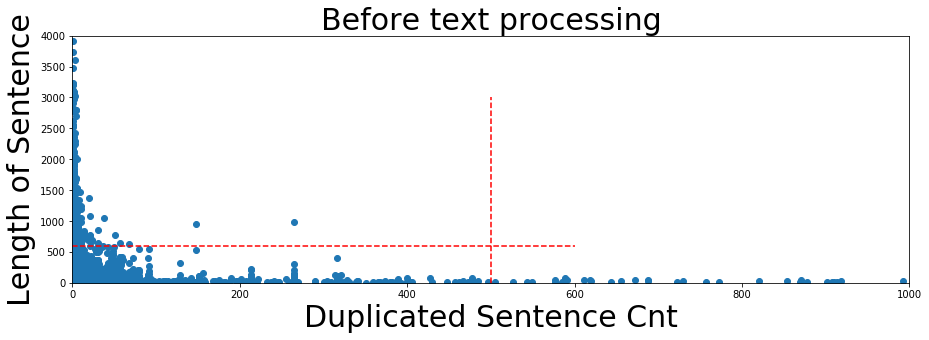

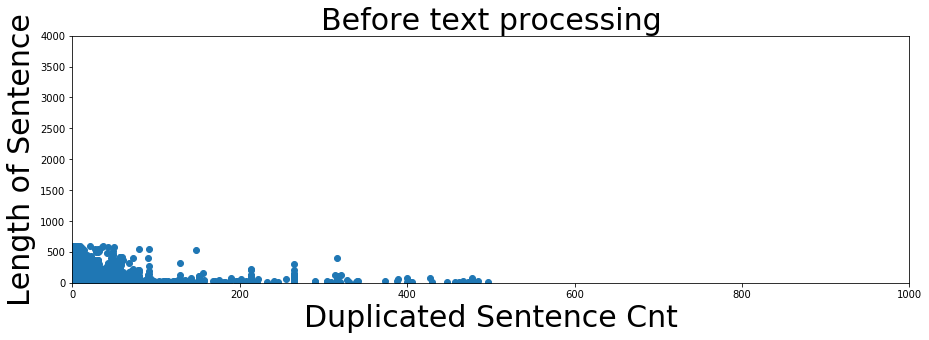

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.scatter(duplic['duplicated_cnt'],duplic['len'] )
plt.vlines(arg_max_dup, 0, 3000, colors = "r", linestyles = "dashed")
plt.hlines(arg_max_len, 0, 600, colors = "r", linestyles = "dashed")

plt.xlabel('Duplicated Sentence Cnt',color='k',  size = 30)
plt.ylabel('Length of Sentence',color='k', size = 30)
plt.xlim(0,1000)
plt.ylim(0,4000)
plt.tick_params(labelsize=10,labelcolor = 'k', colors='k')
plt.title("Before text processing", size =30)
plt.show()


plt.figure(figsize=(15,10))
plt.subplot(212)
plt.scatter(dup['duplicated_cnt'],dup['len'] )
plt.xlabel('Duplicated Sentence Cnt',color='k',  size = 30)
plt.ylabel('Length of Sentence',color='k', size = 30)
plt.xlim(0,1000)
plt.ylim(0,4000)
plt.tick_params(labelsize=10,labelcolor = 'k', colors='k')
plt.title("Before text processing", size =30)
plt.show()



## 3.4 string processing 
- By regex 
    - remove symbol [’_!"#$%&""\'""''()*+,-./:;<=>?@[\\]^`{|}~“”（）]
    - substitute number with "x"
    - lower case
    - remove chinese

- By NLTK <font color='red'> </font>
    - Further lemmatization will be implented in activities extraction part.


In [17]:
dup.head()

,text,duplicated_cnt,len
1,"""Agency first"" mentality\n",1,25
2,"""DO NOT"" call the salon directly regarding the hiring thanks\n",1,61
3,"""It makes me feel good knowing that we make the residents’ lives better. We laugh with them, cry with them, sing and dance with them – we brighten their day. Working here is an unbelievable privilege and it will be something I carry with me for the rest of my life!"" Sunrise Team Member\n",1,287
4,"""Make it so"" Attitude: We expect you to be part of the solution. We are a growing company and it's all-hands-on-deck when it comes to turning ideas into action. Enough said!\n",5,174
5,"""What is your favorite ice cream flavor and why?""\n",2,50


### 3.4.0 test regex


In [18]:
### test regex - 1 

# Preprocessing = string method + regex 

# regex_ch = re.compile(r'[\u4e00-\u9fa5]+')  
# regex_pat = re.compile(r'[\d]', flags=re.IGNORECASE) 
# regex_punctuation = re.compile(r'[’_–：!"#$%&""\'""•''()*+,-./:;<=>?@[\\]^`{|}~“”（）]') 
# regex_underline = re.compile(r'[_]')

# corpus = dup['text'].str.replace(regex_ch, '').str.replace(regex_underline, '').\
# str.replace(regex_pat, 'X').str.replace(regex_punctuation, ' ').str.strip()\
# .str.lower()



In [19]:
### test regex - 2

# A=pd.Series(["--abcdefghijklmnopqrstuvwxyz","'d:g_  rgr",".,fad__  s52","_defin我rtsuvywyye","544","w   我的2fds1321","xxeeexxx","aaaa"])
# regex_ch = re.compile(r'[\u4e00-\u9fa5]+') 
# regex_pat = re.compile(r'[\d]', flags=re.IGNORECASE) 
# regex_punctuation = re.compile(r'[_!"#$%&\'""''()*+,-./:;<=>?@[\\]^`{|}~]') 
# regex_underline = re.compile(r'[_]')

# corpus = A.str.replace(regex_underline, '').\
# str.replace(regex_pat, 'XXX').str.replace(regex_punctuation, ' ')\
# .str.lower()

# # check the feature space
# len(tfidf_vect.get_feature_names())

# tfidf_vect.get_feature_names()

# corpus = A.str.replace(regex_ch, '').str.replace(regex_underline, '').\
# str.replace(regex_pat, 'X').str.replace(regex_punctuation, ' ')\
# .str.lower()
# corpus



# # TfidfVectorizer does need to join corpus
# tfidf_vect = TfidfVectorizer(stop_words="english")  
# tfidf = tfidf_vect.fit_transform(corpus)



### 3.4.1 Regex
- extracting RE pattern of [a-zA-Z0-9][-._a-zA-Z0-9]*[a-zA-Z0-9]
- substitute number with "X"
- should not remove stop words now, because we need to keep the context for latter models.
    - Before the Vectorization, we can delete them if we want.

In [20]:
def reg(text):
    pattern = r'[a-zA-Z0-9][-._a-zA-Z0-9]*[a-zA-Z0-9]'
    
#     stop_words = nltk.corpus.stopwords.words('english') # load stopword

    # str(text) to ensure the list are transform to string    
    tokens = [token for token in nltk.regexp_tokenize(str(text).lower() , pattern)]
#                 if token not in stop_words]  # tokenize!
    return " ".join(tokens)

regex_pat = re.compile(r'[\d]', flags=re.IGNORECASE) 
corpus = dup['text'].apply(reg).str.replace(regex_pat, 'X')

In [21]:
corpus = pd.DataFrame(corpus)
corpus.iloc[10:100]

,text
11,in new york america best hospitals XXXX-XXXX u.s.news world report
14,li-ajX csacb
15,li-dfX cb
17,li-jzX csacb
20,li-ppX qualifications null additional information all your information will be kept confidential according to eeo guidelines
...,...
105,vox financial partners value inclusiveness and aspire to reflect this in our workforce we welcome applications from people from all sections of the community irrespective of ethnicity gender age disability sexual orientation religion or belief
106,you must be XX or older to apply for this position customer service experience wanted
107,accepting applications
108,an awesome companion-animal general practice


## 3.4.2 Preprocessed data distribution
- Check the description of data 
    - we need to lower down the std
- Count the freq/length for the new_corpus

In [22]:
# Count the length and duplicated for # After cleaning dataset
A = list(corpus['text'].copy().T)
AA = s_cnt(list(A))
AAA = dup_cnt(AA)

# arg_max_dup = 500
# arg_min_len = 10
# arg_max_len = 4000

# corpus_new = rm_dup(AAA, max_dup = arg_max_dup, min_len = arg_min_len , max_len = arg_max_len ) 
corpus_new = AAA

# saving freq/length data for visulization 
dup_cl = corpus_new.copy()

# next pipeline input data corpus_cl
corpus_cl = pd.DataFrame([' '.join(i.split()) for i in corpus_new['text'].copy()])

count    54686.000000
mean        89.688183
std         91.979898
min          0.000000
25%         36.000000
50%         60.000000
75%        101.000000
max        587.000000
Name: cnt, dtype: float64


In [23]:
corpus_new.sort_values('len',ascending=False)

,text,duplicated_cnt,len
44086,the facilities assistant is responsible for providing customer service to potential rental clients and assists the event and marketing coordinator with all logistical aspects of the national museum on-site facilities rental program this position interfaces with the potential clients and assists them in booking and some planning of their event once an event is booked the assistant works closely with event and marketing coordinator to implement the event this position includes weekend and evening hours and requires some flexibility on scheduling based upon facilities rental schedule,1,587
17800,for over XX years schlesinger group has provided data collection services that help companies understand their potential influences in the marketplace over this time we have amassed the technical expertise and extensive market knowledge to provide our clients with comprehensive range of quantitative and qualitative research services in desirable markets to achieve this we have established high standards of professionalism and commitment based on our values of partnership quality and service excellence standards against which we measure ourselves on every project that we undertake,1,586
44661,the receptionist is responsible for providing front desk and administrative support to ensure optimal customer service and patient engagement through effective and efficient patient care processing this position is vital to the patient care team and is instrumental in guiding the patient through the health care processes involved with their visit in addition this position is essential in the revenue cycle process by ensuring correct data entry of patient demographics thorough assessment of health care coverage accurate health care coverage posting and appropriate cash collections,2,586
22998,job summary receptionist is responsible for answering the phone scheduling patients greeting patients checking patients in verifying insurance eligibility and providing initial exam work-up for providers receptionists will be responsible for calling in referrals check out patients and collect all applicable co-pays receptionists will be the first point of contact for patients and need to be able to listen to patients chief complaints and concerns and prioritize the booking of their appointments as well as direct them to who they would need to speak with to get the help they need,1,585
23421,key responsibilities include sterilize and disinfect instruments and equipment prepare treatment rooms instruments and tray setups for periodontal procedures greet and prepare patients for treatment operate digital x-ray equipment including intra oral camera pictures assist the dentist during examinations and treatment procedures record medical and dental histories and vital signs of patient before and after treatment provide postoperative instructions prescribed by dentist after dental procedures record treatment information in patient records assist with other duties as needed,1,585
...,...,...,...
27388,minimum,1,7
41685,skills,1,6
28042,months,1,6
15255,eoe,1,3


In [24]:
corpus_new.sort_values('duplicated_cnt',ascending=False)

,text,duplicated_cnt,len
40093,salary XX.XX to XX.XX hour,136,26
40070,salary XX XXX.XX to XX XXX.XX year,53,34
0,,32,0
40088,salary XX.XX hour,31,17
20796,high school diploma or equivalent,19,33
...,...,...,...
17324,finding solutions to guest problems,1,35
17326,fine and or gross motor skills including the ability to grasp lift and or carry or otherwise move packages on standard wheeled cart with load capacity of XXXlbs,1,160
17327,fine dexterity with hands steadiness,1,36
17328,fine motor skills adequate for utilizing office equipment such as computers telephones copiers fax machines etc.duties,1,118


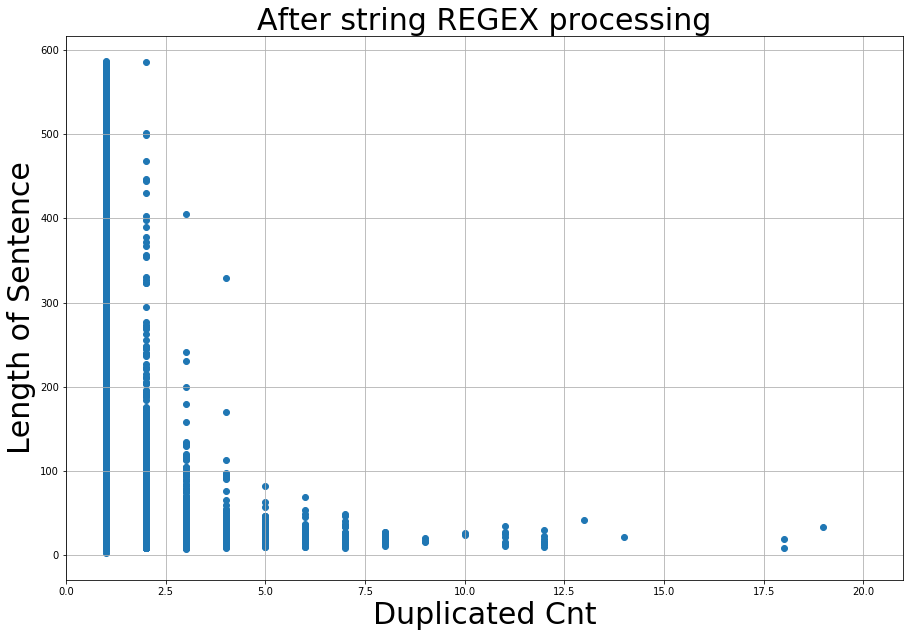

In [25]:
plt.figure(figsize=(15,10))
plt.scatter(dup_cl['duplicated_cnt'],dup_cl['len'] )
#     plt.xlim(0, xlim)
#     plt.ylim(0, ylim)
plt.xlabel('Duplicated Cnt',color='k',  size = 30)
plt.ylabel('Length of Sentence',color='k', size = 30)
plt.xlim(0, 21)
plt.tick_params(labelsize=10,labelcolor = 'k', colors='k')
plt.grid()
plt.title("After string REGEX processing", size =30)
plt.show()

In [26]:
corpus_cl.head(10)

,0
0,
1,X-X weekends shifts per year
2,X-X year prior sales experience plus
3,X-X years
4,X-X years X-X years experience in reception and general office
5,X-X years accounts payable experience is required
6,X-X years administrative accounting experience
7,X-X years administrative experience required
8,X-X years administrative support experience
9,X-X years as receptionist or personal assistant


In [27]:
corpus_cl[1:10]

,0
1,X-X weekends shifts per year
2,X-X year prior sales experience plus
3,X-X years
4,X-X years X-X years experience in reception and general office
5,X-X years accounts payable experience is required
6,X-X years administrative accounting experience
7,X-X years administrative experience required
8,X-X years administrative support experience
9,X-X years as receptionist or personal assistant


# 3.5 Wordcloud
- Generate wordcloud with mask (NLP background picture)

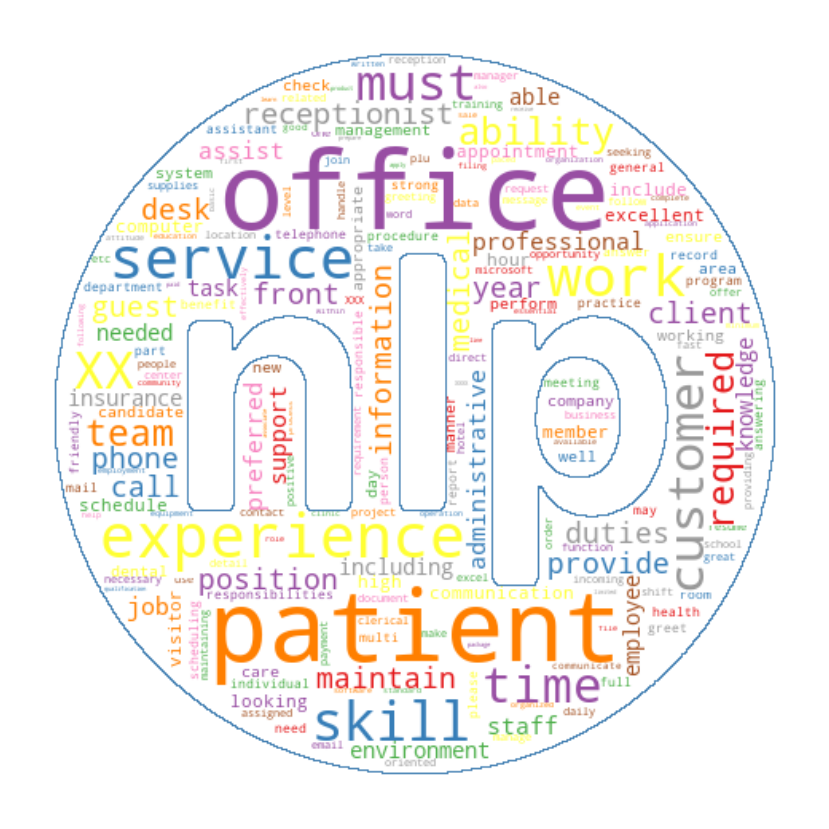

In [28]:

text = " ".join(corpus_cl.iloc[:,0])

stop_words = stopwords.words('english') # load stopword
alice_mask = np.array(Image.open("E:/nlp-1.png")) 
wordcloud = WordCloud(mask=alice_mask,background_color='White', max_words=200
                      ,contour_width=1, contour_color='steelblue',stopwords = stop_words, collocations = False, colormap =  "Set1").generate(text);


# wordcloud = WordCloud(background_color='Black', max_words=200
#                       ,contour_width=0, contour_color='steelblue',stopwords = stop_words, collocations = False, colormap =  "Set1").generate(text);


plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear");
plt.axis("off");
plt.show();

# 3.6 Data Saving

In [29]:
# # Saving for Labeling and Kmeans evaluation
# outdir = 'C:/Users/Verdi/OneDrive - stevens.edu/Stevens BIA/660/BIA 660 Project_AI_jobs/ABAE/Attention-Based-Aspect-Extraction-master/datasets/'
# corpus_cl.to_csv(outdir+'train_v'+str(version)+'.txt',encoding='utf-8', index=None, header=None)

# 4. Model Framework
- Model1 - Kmeans: unique  
    - Hyper parameters: <font color=red> K= 3 to 46 </font> (In testing, we only use k=30 to 46 )
    - Input: TFIDF - matrix, unique sentence 50000+ sentences (In testing, we only use 20000 sentences)
    - Filter: stop_words="english", min_df = 10
    
- Evaluation
    - Mannualy label 1000 sentences with "Activities related:1" / " Not related:0"
        - Internal method 
            - Cohension (Intra-cluster similarity)
            - Separation (Inter-cluster dissimilarity)
        - External method
            - Cross entropy
- Verify
    - Choose the best K within Sentiment framework 
        - visulization 
        - positive:
               'ability','able to',abilities','maintain','ensure','skills','responsible','knowledgeable','knowledge','proficient','excellent','familiarity','familiar','require'
        - negtive: 
                'experience','education','salary','benefits','benefit','vacation','resume','preferred','part-time','full-time','equal','discriminate','without','diploma'
        - Dataset with the higher postive clusters are what we need to extract. These dataset are used for Extraction activities ( most of them are relate to activities, and we hope we can filter some noise in this way.)

- Conclusion: combined the evaluation graph and mannually check the dataset, we choose K=42

    <br> <br/>
 
<font color='green'>* The models above will be used to filter some noise of the models below. For example, we only keep the activities relevent clusters dataset into next steps. </font> 
 
 <br> <br/>


- Model2 - LDA
    - Further data preprocessing: Lemmatization
    - Gridsearch
    - Visulization the best model
    - Mannually check the result

- Model3 - Atention Based Aspects Extraction (ABAE)
    - Two version:  I have seperate them with another files
        - Google colab (The codes are little bits different, need to upload and set in colab)
        - Local computer
    - To run the code, I have integrated it into a Ipython file (Be sure that dataset existed in the file)
        - preprocess the train file (data extract from kmeans result, which is relevant to activities)
        - W2V, Use gensim package to train our own word embedding
        - Adjust parameters
        - Run the code and save the result

    - Mannualy check the result and find some similiar characteristics in one aspects
  

#### 4.0 Note
- In this file, we only keep K=42 since it is quite computing expensive.
- We used google colab to run our dateset with K = 3 to 46 and choose the best Parameters for pipeline. (The dimension of the TF-IDF cost lost of computational resources)
- The Ipython file is name "k_cluster_select".


#### 4.1.1 test Kmeans speed with all dataset
   - K=42, sentence = 50000+ (The K parameter came from the evaluation below) 
   - deleted the stop word in there
   - when min_df=10, features = 3698
   - when min_df=5, features = 5000+ 
   - when min_df=1, features = 17000+

In [30]:
%%time
# TfidfVectorizer does need to join corpus


corpus_cl_list = list(corpus_cl.iloc[0:e_test,0])
corpus_cl_list = list(corpus_cl.iloc[:,0])

# deleted the stop word in there
# when min_df=5, features = 5000+ 
# when min_df=1, features = 17000+
tfidf_vect = TfidfVectorizer(stop_words="english", min_df=arg_min_df)  
tfidf = tfidf_vect.fit_transform(corpus_cl_list)  # Feature space

tfidf_vect.get_feature_names()
# check the feature space
print('DATASET Summary from begining: \n  Before preprocessing, dup.len:', dup.shape[0])
print('  After preprocessing, corpus_cl_list.len:', len(corpus_cl_list))
print('\nFeature space length:', len(tfidf_vect.get_feature_names()))
print('\nTfidf.shape:', tfidf.shape)

## Check feature space
# a=tfidf_vect.get_feature_names()
# a[::-1] 
k = arg_k

kmeans = KMeans(n_clusters = arg_k).fit(tfidf)
label = pd.DataFrame(kmeans.labels_, columns=['label'])
# kmeans.labels_ # label
# labels = kmeans.predict(x_train).tolist()

DATASET Summary from begining: 
  Before preprocessing, dup.len: 54686
  After preprocessing, corpus_cl_list.len: 50551

Feature space length: 3698

Tfidf.shape: (50551, 3698)
Wall time: 4min 21s


In [31]:

# ## result = corpus_cl.join(label, how="inner",rsuffix='_cleaned')
# # result = dup.join(label, how="inner").join(pd.DataFrame(corpus_cl), how="inner",rsuffix='_cleaned')
# # result[1:100] 

# outdir = 'C:/Users/Administrator/OneDrive - stevens.edu/Stevens BIA/660/BIA 660 Project_AI_jobs/ABAE/Attention-Based-Aspect-Extraction-master/datasets/'
# result.to_csv(outdir+'Kmeans_'+str(arg_k)+'_v'+str(version)+'.csv',encoding='utf-8')

### 4.2 Model1 - Kmeans: unique sentences
   - Hyper parameters: <font color=red> K= 3 to 46 </font> (30 for efficiency)
   - Input: TFIDF - matrix, unique sentence 50000+ sentences
   - Filter: stop_words="english", min_df = 5 (10 for efficiency)
   - Distance measure: L2 distance 
       - note: kmeans in Sklearn package cannot determine similarity distance measure
       - Further improvement: try nltk package
   
    
<font color='green'>* When we labeled the data, the dataset is not that clean, but now we have fixed it. At this time, we only use the label dataset before to choose best K because of the time constraint. </font> 

<font color='green'>* We have run total 50000+ sentence in google colab. However, in this file, we only use half dataset to test the codes below. The computational resources is too limited to take account all dataset. </font> 

##### 4.2.0  In there, we mannually labeled 1000 sentences with "Activities related:1" / " Not related:0"  

In [32]:
df = pd.read_csv(main_path+'/Jd_text_labels.txt',header=1
                 , names=["label","text"] ,encoding = "ISO-8859-1") # this is an encoding way that avoid errors

# Further clean punctuation to avoid error in kmeans
def cl(d):
    d = " ".join([i.strip(string.punctuation) for i in d.split()])
    return d
df.text = df.text.apply(cl) 

df.head(10)

,label,text
0,1.0,job summary serves visitors by greeting welcoming and directing them appropriately notifies company personnel of visitor arrival maintains security and telecommunications system
1,1.0,excellent and effective social skills along with good communication skills both verbal and written client facing experience required
2,0.0,every year thousands of guests stay at seabrook by booking one of over xxx homes in our cottage rentals program the front desk team is the face of seabrook weæ³è´re looking for a friendly individual who can manage multiple tasks at once and is passionate about hospitality and guest service hours for the front desk are varied and weekends are mandatory c
3,1.0,maintain and order office supplies including printed material and other supplies
4,1.0,order front office supplies and keep inventory of stock
5,0.0,æ³æ techniquesas described in the employee handbook.er
6,1.0,educate and advise clients regarding premier services and practices
7,1.0,monitor check-ins to identify delinquent accounts and handle each delinquent account professionally
8,0.0,job type support staff union
9,0.0,office experience a must


##### 4.2.1  TfidfVectorizer

In [33]:
##### use kmeans in sklearn package, rather than NLTK package.
from nltk.cluster import KMeansClusterer,cosine_distance
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

In [163]:
#* TF-IDF
df_l = df
# df_l = df.iloc[0:e_test]

pattern = r'[a-zA-Z0-9][-._a-zA-Z0-9]*[a-zA-Z0-9]'

tfidf_vect = TfidfVectorizer(stop_words="english", min_df=10, encoding='utf-8',decode_error='strict',token_pattern=pattern) 

dtm= tfidf_vect.fit_transform(df_l['text'])
dtm.shape

(54205, 4257)

##### 4.2.2 Kmeans initialized

In [164]:
def kmeans(num_clusters):
    clusterer = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, 
                       max_iter=10, tol=0.0001, precompute_distances='auto', 
                       verbose=0, random_state=None, copy_x=True, n_jobs=8, 
                       algorithm='auto')
#     clusterer = KMeansClusterer(num_clusters,cosine_distance, repeats=3, conv_test=1e-03,avoid_empty_clusters=True)#,rng = random.Random().seed(1))
    clusterer.fit(dtm.toarray())
    clusters = clusterer.labels_
    centroids = clusterer.cluster_centers_
    return centroids, clusters


In [156]:
k_ave_dists_inner=[] 
k_ave_dists_outer=[] 

In [157]:

for knum in range(k_begin,k_end):
    centroids,clusters = kmeans(knum)  
    
    for k in range(knum):
        centroid = centroids[k] 
        k_idx=[]
        for idx,val in enumerate(clusters): 
            if val==k:
                k_idx.append(idx)
                
        dists=0
        for idx in k_idx: 
            dist = euclidean_distances(centroid.reshape(1,-1),dtm[idx])
            dists += dist
        ave_dist.append(dists/len(k_idx))

    s=0
    for i in ave_dist:
        s += i
    k_ave_dists_inner.append(s/len(ave_dist))

    dists_outer = 0
    count=0
    for i in range(len(centroids)):
        for j in range(i+1,len(centroids)):
            dist_outer = euclidean_distances(centroids[i].reshape(1,-1),centroids[j].reshape(1,-1))
            dists_outer += dist_outer
            count += 1
    ave_dist_outer = dists_outer/count
    k_ave_dists_outer.append(ave_dist_outer)
    print('%d finished'%knum)

3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
10 finished
11 finished
12 finished
13 finished
14 finished
15 finished
16 finished
17 finished
18 finished
19 finished
20 finished
21 finished
22 finished
23 finished
24 finished
25 finished
26 finished
27 finished
28 finished
29 finished
30 finished
31 finished
32 finished
33 finished
34 finished
35 finished
36 finished
37 finished
38 finished
39 finished
40 finished
41 finished
42 finished
43 finished
44 finished
45 finished


##### 4.2.2 pipeline could stop here. we choose the cluster to construct our new dataset

#### 4.3 Evaluation
- Internal method 
    - Cohension (Intra-cluster similarity)
    - Separation (Inter-cluster dissimilarity)
- External method
    - Cross entropy

- Conclusion: combined the evaluation graph and mannually check the dataset, we choose K=42


In [158]:
k=list(range(k_begin,k_end))
inner = [i[0][0] for i in k_ave_dists_inner]
outer = [i[0][0] for i in k_ave_dists_outer]

<function matplotlib.pyplot.show(*args, **kw)>

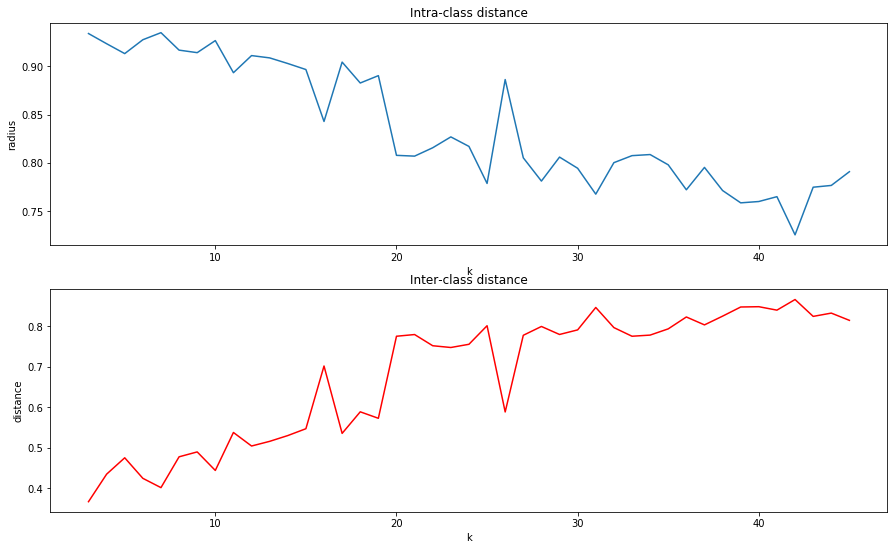

In [159]:
plt.figure(figsize=(15,9))

plt.subplot(211)
plt.plot(k,inner,label='inner')
plt.xlabel('k')
plt.ylabel('radius')
plt.title('Intra-class distance')
plt.show

plt.subplot(212)
plt.plot(k,outer,'r',label='outer')
plt.xlabel('k')
plt.ylabel('distance')
plt.title('Inter-class distance')
plt.show

In [160]:
#* elbow end

In [161]:
#* entropy start
%% time
import math 
entropy_ave = [] 
entropy_k=[]

for kmun in range(k_begin,k_end):
    centroids,clusters = kmeans(kmun)
    for k in range(knum):
        nlabel=[]
        for idx,val in enumerate(clusters):
            if val == k:
                nlabel.append(df_l['label'].iloc[idx])
        label_count = pd.value_counts(nlabel) 
        try:
            p0 = label_count.loc[0.0]/len(nlabel)
        except KeyError:
            p0 = 0
        try:
            p1 = label_count.loc[1.0]/len(nlabel)
        except KeyError:
            p1 = 0
        if p0 and p1 !=0:
            entropy_n = -p0*math.log(p0,2)-p1*math.log(p1,2)
        else:
            entropy_n = 0
        entropy_k.append(entropy_n)
    entropy_ave.append(np.mean(entropy_k)) 
    print('%d finished'%kmun)     

UsageError: Line magic function `%%` not found.


In [ ]:
k=list(range(k_begin,k_end))
plt.plot(k,entropy_ave,'g')
plt.xlabel('k')
plt.ylabel('average entropy')
plt.title('Entropy under each k')


#### 4.4 Visualize and verify with  Sentiment frame
- We choose mannually oberserve keywords to measure how many sentence in each cluster and visualize it
    - positive:
           'ability','able to',abilities','maintain','ensure','skills','responsible','knowledgeable','knowledge','proficient','excellent','familiarity','familiar','require'
    - negtive: 
            'experience','education','salary','benefits','benefit','vacation','resume','preferred','part-time','full-time','equal','discriminate','without','diploma'
- Dataset with the higher postive clusters are what we need to extract. These dataset are used for Extraction activities ( most of them are relate to activities, and we hope we can filter some noise in this way.)

In [ ]:
positive = ['ability','abilities','maintain','ensure','skills','responsible','knowledgeable','knowledge','proficient','excellent','familiarity','familiar','require']
negative = ['experience','education','salary','benefits','benefit','vacation','resume','preferred','part-time','full-time','equal','discriminate','without','diploma']

In [ ]:
# Get each kmeans sentiment score based on index (Haven't integrated the code. And will should run Kmeans again)
def k_scor(knum,dtm):
    voc_lookup= tfidf_vect.get_feature_names() 
    index_value={i[1]:i[0] for i in tfidf_vect.vocabulary_.items()}
    fully_indexed = []

    for row in dtm:
        fully_indexed.append([column for (column,value) in zip(row.indices,row.data)])

    idx=list()
    posi=list()
    nega=list()

    for document_idx in range(len(fully_indexed)):
        posi_count = 0
        nega_count = 0
        for word_idx in fully_indexed[document_idx]:
            if voc_lookup[word_idx] in positive:
                posi_count += 1
            elif voc_lookup[word_idx] in negative:
                nega_count += 1
            else:
                continue
        idx.append(document_idx)
        posi.append(posi_count)
        nega.append(nega_count)
      # doc = pd.DataFrame({'doc_idx':list(document_idx)})#,'positive number':posi_count,'negative number':nega_count})

    docs = pd.DataFrame({'doc_idx':idx,'positive number':posi,'negative number':nega})
    k_posi=[]
    k_nega=[]
    
    centroids,clusters = kmeans(knum) 
    for k in range(knum):
        cluster_idx=[]
        for idx,val in enumerate(clusters):
            if val == k:
                cluster_idx.append(idx)
        doc_clustert = pd.DataFrame({'doc_idx':cluster_idx})
        df_merge = pd.merge(doc_clustert,docs,on='doc_idx',how='inner')
        sum_nega=0;sum_posi=0
        for i in df_merge['positive number']:
            sum_posi += i 
        for j in df_merge['negative number']:
            sum_nega += j
        k_posi.append(sum_posi)
        k_nega.append(sum_nega)
    print('%d finished'%knum) 
#     print("\nPositive count in each cluster:",k_posi,"\nNegative count in each cluster:" ,k_nega)
    return k_posi, k_nega

def get_chart(right_labels, left_labels,k_num):
    # remove_edge(plt)
#     plt.figure(figsize=(15,5))
    fig, ax = plt.subplots(figsize=(20,10))
    b = np.array(right_labels)
    a = np.array(left_labels)
    plt.yticks(list(range(k_num)))
    plt.xticks()
    plt.title('positive vs negative (%d clusters)'%k_num)
    rect_a = plt.barh(range(len(a)), a, color='#ED7C30', height=0.5)
    rect_b = plt.barh(range(len(b)), -b, color='#9DC3E7', height=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     plt.xticks（rotation = 180）
    plt.show()

42 finished


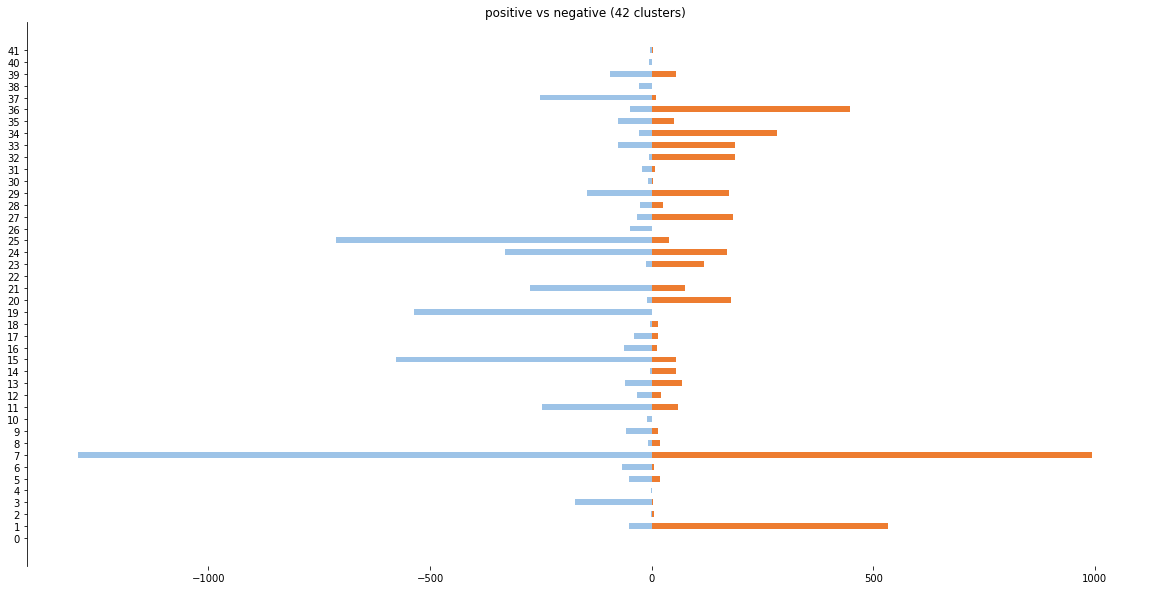

In [45]:
# for kk in range(k_begin,k_end):
kk = 42

k_posi,k_nega = k_scor(kk,dtm)
get_chart(k_posi,k_nega,kk)
# pd.DataFrame([k_posi,k_nega]).T.rename(columns={1:"positive", 0:"negative"})

43 finished


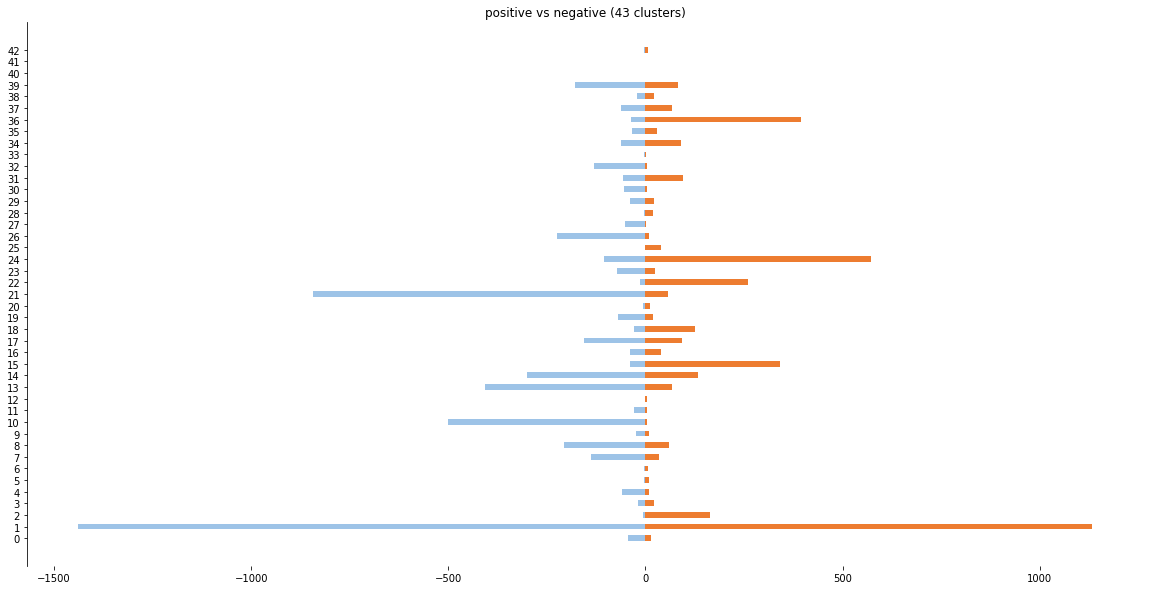

In [46]:
# for kk in range(43,48):
kk = 43
k_posi,k_nega = k_scor(kk,dtm)
get_chart(k_posi,k_nega,kk)
# pd.DataFrame([k_posi,k_nega]).T.rename(columns={1:"positive", 0:"negative"})

44 finished


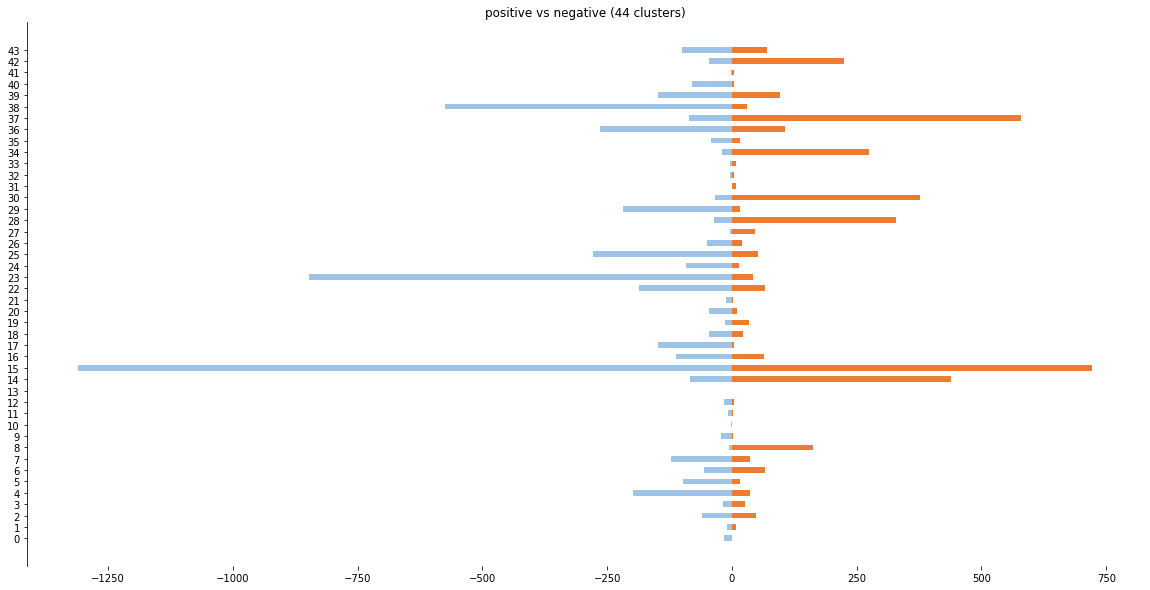

In [47]:
# for kk in range(43,48):
kk = 44
k_posi,k_nega = k_scor(kk,dtm)
get_chart(k_posi,k_nega,kk)
# pd.DataFrame([k_posi,k_nega]).T.rename(columns={1:"positive", 0:"negative"})

## 4.5 Conclusion 
   - From the evaluation result and sentiment graph, we find the more clusters the better performance within the labeled dateset.
   - To make sure that the sentences extracted from kmeans are relevant to activities, we also mannually check the result.

   - Finally, we determined K = 42, and extracted the most extinct four as our next step input.

#### 4.6 Saving the result 

In [48]:
def best_result_save(best_k):

    _ ,clusters = kmeans(best_k)
    df_clustered = pd.concat([df_l['text'], pd.DataFrame(clusters)], axis=1).rename(columns={0:'Result'})


    for j in range(best_k):
        MyFile = open(arg_k_42_result_save+ 'temp_ans_' + str(best_k) + '_' +str(j) + '.txt','w',encoding='utf-8')
        for i in df_clustered[df_clustered['Result'] == j+1]['text'].tolist():
            MyFile.write(i)
            MyFile.write('\n\n\n')

    MyFile.close()
    print('Done, saved in %s'%arg_k_42_result_save)
    return None

best_k = 42
best_result_save(best_k)

Done, saved in C:/Users/Administrator/OneDrive - stevens.edu/Stevens BIA/660/BIA 660 Project_AI_jobs/Kmean_42_result/


# 5 Activities Extraction Model
- In this part, we implented two models
    - <font color=red> LDA</font> Model
        - Gridsearch
        - Visulization the best model
        - Mannually check the result
    - <font color=red> Attention Based Aspects Extraction </font> - ABAE Model
        - Two version:  I have seperate them with different files
            - Google colab (The codes are little bits different, need to upload and set in colab)
            - Local computer
        - To run the code, I have integrated it into a Ipython file (Be sure that dataset existed in the file)
            - preprocess the train file (data extract from kmeans result, which is relevant to activities)
            - W2V, Use gensim package to train our own word embedding
            - Adjust parameters
            - Run the code and save the result
            
        - Mannualy check the result and find some similiar characteristics in one aspects

### 5.1 LDA - test

In [51]:
corpus_txt = [' '.join(i.split()) for i in corpus_new['text'].copy()]

import gensim
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pyLDAvis
import pyLDAvis.gensim

tf_vectorizer = CountVectorizer(max_df=0.90, min_df=50, stop_words='english')
tf = tf_vectorizer.fit_transform(corpus_txt)

NUM_TOPICS = 10
X_train, X_test = train_test_split(tf, test_size=0.1, random_state=0)
corpus = gensim.matutils.Sparse2Corpus(X_train, documents_columns=False)
id2word={idx:w for idx, w in enumerate(tf_vectorizer.get_feature_names())}
dictionary = corpora.Dictionary.from_corpus(corpus, id2word=id2word)

ldamodel = gensim.models.ldamodel.LdaModel(corpus, alpha='asymmetric',num_topics = NUM_TOPICS, id2word=id2word, iterations=15)



lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\Administrator\Anaconda3\envs\py36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## 5.2 LDA - Full

 ####  5.2.0 Data preparing and loading
 - Reading the dataset that we saved in Kmean_42_result in the 4.6

In [60]:
# For seperate clusters.txt file input. This code can mark the sentiment words
# main_path = "C:/Users/Administrator/OneDrive - stevens.edu/Stevens BIA/660/BIA 660 Project_AI_jobs/"
arg_k_42_result_save = main_path+"Kmean_42_result/"
docs = os.listdir(arg_k_42_result_save)
positive = ['ability','able to', 'abilities','maintain','ensure','skills','responsible','knowledgeable','knowledge','proficient','excellent','familiarity','familiar','require']
negative = ['experience','education','salary','benefits','benefit','vacation','resume','preferred','part-time','full-time','equal','discriminate','without','diploma']

In [62]:
def scor(docs):
    pos = 0
    neg = 0
    d = open(arg_k_42_result_save+docs, encoding='utf-8')
    a = [i for i in d.read().split('\n\n\n')] 
    for xx in a: 
        for xxx in xx.split():
            if xxx in positive:
                pos+=1
            elif xxx in negative:
                neg+=1
    d.close()
    return pos,neg,len(a)
# , pos-neg
# , pos/(pos+neg), pos/len(a)
#     return pos/len(a)

k_score=[]

for i in docs:
    p, n, t= scor(i)
#     k_score.append([i,posi,nega])
    k_score.append([i,p,n, p-n, p/t ])
Senti_chose = pd.DataFrame(k_score)
Senti_chose.columns = ['name','positive','negative','pos-neg','pos/total']
Senti_chose

# Senti_chose.sort_values('positive', ascending =False)
Senti_chose.sort_values(['pos/total','pos-neg','positive'], ascending = False,inplace=True)
Senti_chose.reset_index(inplace=True,drop=True)
Senti_chose.head(6)

,name,positive,negative,pos-neg,pos/total
0,temp_ans_42_7.txt,664,47,617,1.580952
1,temp_ans_42_11.txt,385,11,374,1.492248
2,temp_ans_42_1.txt,777,48,729,1.412727
3,temp_ans_42_30.txt,416,86,330,1.363934
4,temp_ans_42_18.txt,399,4,395,0.975550
5,temp_ans_42_32.txt,172,53,119,0.847291


####  5.2.1 Improve on selection
   - Build this pipeline.
   - Based on sentiment label, we can choose target clusters from kmeans (which is highly relevant to activities/requirements)
   - The key is to decide: 
       - <font color=red> Trade-off (noise V.S. sample size) </font>
       - How to choose ratio of among positive, total_length and negative indicators?
       - How many files we need to select?
       - Is the samples size big enough?
       - Is there noise filter enough?
       

In [132]:
# INPUT = corpus_txt

read_n_files = 10

a = Senti_chose.iloc[0:read_n_files,0]
dat = []
for b in a:
    f = open(arg_k_42_result_save+str(b), encoding='utf-8')
    d = [i for i in f.read().split('\n\n\n')] 
    f.close()
    dat.extend(d)
    
    
test_size = 50000 # For testing, this is neccessary
data = dat[1:test_size]
print("We selected %s sentences as LDA Model input"%len(data))


We selected 4026 sentences as LDA Model input


In [133]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline


# !python -m spacy download en_core_web_sm
# nlp = spacy.load('en')
# spacy.load('en_core_web_sm')
import en_core_web_sm

#### 5.2.2 Further  cleaning and lemmatization
- Use the Spacy package to keeping only tagger component (for efficiency)
- Do lemmatization keeping only Noun, Adj, Verb, Adverb

In [134]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [135]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = en_core_web_sm.load()

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['skill essential', 'computer literate good typing skill']


In [136]:
vectorizer = CountVectorizer(analyzer='word',  min_df=2,  stop_words='english' )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

# Materialize the sparse data, and check the Sparsicity
data_dense = data_vectorized.todense()
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.47561900279760505 %


#### 5.2.3 LDA Model initialize AND test

In [137]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,             
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,           
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)


# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())
# print(lda_model) 

Log Likelihood:  -254737.5199508612
Perplexity:  707.9373541621857
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


#### 5.3 Gridsearch for LDA
- search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

In [138]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\Administrator\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [139]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
        iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method=None,
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=1,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_

In [140]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -101711.28777299935
Model Perplexity:  565.5044887394225


In [141]:
# model.cv_results_

#### 5.4 Best LDA model result
- assign the topics with the higher probabilities
- check the result and distribution of each topics

In [142]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Sentences_" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# 标记数据
def color_green(val):
    color = 'green' if val > .2 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .2 else 400
    return 'font-weight: {weight}'.format(weight=weight)

#
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Sentences_0,0.03,0.38,0.03,0.03,0.03,0.03,0.03,0.03,0.35,0.03,1
Sentences_1,0.02,0.02,0.02,0.02,0.02,0.02,0.19,0.02,0.68,0.02,8
Sentences_2,0.48,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.42,0.01,0
Sentences_3,0.01,0.01,0.28,0.01,0.01,0.01,0.01,0.01,0.62,0.01,8
Sentences_4,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.87,0.01,8
Sentences_5,0.01,0.01,0.01,0.01,0.15,0.01,0.01,0.01,0.76,0.01,8
Sentences_6,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.82,0.02,8
Sentences_7,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.82,0.02,8
Sentences_8,0.15,0.01,0.01,0.01,0.01,0.01,0.3,0.01,0.3,0.16,6
Sentences_9,0.01,0.48,0.01,0.01,0.01,0.01,0.01,0.01,0.41,0.01,1


In [ ]:
#### 5.4.2
- We chose most of 

In [143]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,8,613
1,4,586
2,6,526
3,0,488
4,3,431
5,9,372
6,5,312
7,1,269
8,2,257
9,7,172


#### 5.5 Check the distribution of vocabulary  
- Standard Visulization of LDA model
- Print out the distribution of topic/words and topic/sentences
- Mannually check the final result and try to find the characteristics for each topics
- Ready to compare with the result for ABAE

In [144]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\Administrator\Anaconda3\envs\py36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      163.171432 -358.148651       1        1  18.299829
6      378.869537 -152.646820       2        1  15.175530
8     -153.025238  331.566223       3        1  11.281753
9      -91.483810 -272.409180       4        1  11.230729
3     -340.136963 -170.557251       5        1   9.390741
1      120.479019  -56.189346       6        1   8.418511
5     -110.215813   29.786736       7        1   7.541285
0      101.794022  246.114288       8        1   7.436273
2     -368.699524  125.997993       9        1   6.267207
7      350.382629  143.938766      10        1   4.958141, topic_info=     Category         Freq           Term        Total  loglift  logprob
1585  Default  1050.000000          skill  1050.000000  30.0000  30.0000
420   Default   731.000000       customer   731.000000  29.0000  29.0000
1558  Default   687.000000        service   687.000000  28.0000  28.0000
1     Default  1031.000000        ability  1031.000000  27.0000  27.0000
306   Default   382.000000  communication   382.000000  26.0000  26.0000
...       ...          ...            ...          ...      ...      ...
1203  Topic10    18.968637        patient   189.995312   0.6999  -4.6197
1009  Topic10    16.609263     management   119.637423   1.0296  -4.7525
1667  Topic10    18.555632         strong   300.093240   0.2208  -4.6417
544   Topic10    14.107609      effective    63.458364   1.5005  -4.9158
266   Topic10    13.668285         client   147.444762   0.6258  -4.9474

[624 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         1  0.107592  ability
1         3  0.060096  ability
1         5  0.505004  ability
1         6  0.002908  ability
1         7  0.108561  ability
...     ...       ...      ...
1895      4  0.030857     year
1895      6  0.856281     year
1898      1  0.891570       ³e
1899      5  0.360665       ³æ
1899      9  0.625153       ³æ

[1211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 9, 10, 4, 2, 6, 1, 3, 8])

In [145]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head(10)

,abide,ability,able,absence,absolutely,abuse,academic,accept,access,accessible,...,worldæ,write,writing,written,www,year,yearsæ,³a,³e,³æ
Topic0,2.099894,1.253047,0.100024,0.100000,0.100000,0.100000,0.100012,0.100001,0.100065,0.100001,...,0.100000,0.100007,0.100004,0.100001,0.100002,0.100009,0.100004,0.100000,0.100003,0.100009
Topic1,0.100000,3.032115,0.100013,0.100000,6.100011,0.100000,0.100000,0.103157,0.100000,0.100000,...,1.099996,0.100007,0.100000,0.100012,0.100000,114.107592,0.100076,0.100000,0.250988,0.100017
Topic2,0.100062,137.446436,0.100019,0.100024,0.100004,0.100000,0.100006,0.100047,0.100000,0.100005,...,0.100000,36.393950,0.100010,3.099995,0.100000,0.100002,0.100000,0.100000,0.100036,26.830617
Topic3,0.100000,540.289565,12.272151,0.100027,0.100032,0.100022,0.100000,0.100000,0.100001,0.100000,...,0.100000,0.100019,14.855192,0.100000,0.100000,0.100005,0.100011,0.100004,0.100005,15.369312
Topic4,0.100000,117.363572,120.897969,3.099905,1.099947,1.099972,0.100027,8.179084,0.100004,1.634335,...,0.100116,0.100003,0.100006,0.100000,4.099966,14.972606,3.099842,2.702472,11.948873,0.100004
Topic5,0.100044,116.773637,3.567308,0.100013,0.100000,0.100091,0.100107,0.100017,18.099894,0.100005,...,0.100009,0.100009,0.100004,1.099983,0.100016,0.100007,0.100040,0.497489,0.100044,0.100004
Topic6,0.100000,0.113571,50.781817,0.100010,0.100000,0.100000,0.100000,0.100018,0.100003,0.100012,...,1.099878,0.100002,0.100001,0.100000,0.100016,0.100022,0.100000,0.100007,0.100005,0.100010
Topic7,0.100000,87.866200,6.987088,0.100000,0.100000,0.100000,1.100025,0.100004,0.100020,2.565636,...,0.100000,0.100016,0.100002,0.100000,0.100000,0.100007,0.100004,0.100028,0.100010,0.100010
Topic8,0.100000,67.761844,9.862236,0.100021,0.100006,1.099915,2.099822,0.100013,0.100013,0.100000,...,0.100000,184.805977,11.344778,0.100009,0.100000,0.100007,0.100020,0.100000,0.100010,0.100011
Topic9,0.100000,0.100013,1.331377,0.100000,0.100000,0.100000,0.100000,3.017658,0.100000,0.100007,...,0.100000,0.100008,0.100003,0.100000,0.100000,4.219743,0.100003,0.100000,0.100028,0.100006


## 5.6 LDA Final Topic result  
- This is the final result, which will be compared with next ABAE model

In [146]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Voc '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Voc 0,Voc 1,Voc 2,Voc 3,Voc 4,Voc 5,Voc 6,Voc 7,Voc 8,Voc 9,Voc 10,Voc 11,Voc 12,Voc 13,Voc 14
Topic 0,area,word,maintain,office,computer,knowledge,software,clean,include,reception,work,outlook,proficient,use,application
Topic 1,experience,service,customer,knowledge,year,prefer,medical,work,require,position,skill,previous,business,minimum,dealership
Topic 2,record,ability,file,medical,multitask,maintain,instruction,report,write,electronic,patient,follow,work,type,read
Topic 3,ability,work,task,high,maintain,handle,multiple,prioritize,multi,level,communicate,effectively,manage,deadline,pressure
Topic 4,work,environment,team,look,fast,able,ability,care,people,paced,patient,independently,individual,friendly,candidate
Topic 5,knowledge,maintain,ability,procedure,require,office,policy,medical,stand,problem,include,general,time,standard,perform
Topic 6,receptionist,look,time,desk,work,position,seek,team,medical,office,join,hour,day,schedule,candidate
Topic 7,ability,work,maintain,staff,effectively,interact,public,level,communicate,resident,member,use,relationship,develop,appearance
Topic 8,skill,communication,excellent,strong,write,organizational,interpersonal,verbal,good,computer,attention,ability,management,require,multi
Topic 9,customer,service,provide,client,phone,answer,excellent,patient,exceptional,maintain,guest,datum,need,sale,greet


### 5.7 LDA Conclusion
 - This result is compared with ABAE Model that we implemented later.
 - It is harder than ABAE's result to entitle the categories for each topics. Because the input dataset is the sentence rather than the document. This limit LDA's ability to cluster activities.
 - Neural network model can perform better than LDA

#### 5.8 LDA features clustering
- This is to check the separation of Topics. With the input of all sentences, their probability distribution mapped into two dimensions. And we can check the different classes separated enough

    - Implemented Kmeans to cluster different sentences based on the LDA topic probability features 
    - Implemented SVD model to map the LDA feature space into two dimensions
    - Visualization in two dimensions


In [147]:
lda_output.shape

(4026, 10)

In [148]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=10, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.26  0.18  0.16  0.3   0.41  0.18  0.38  0.13  0.59  0.26]
 [-0.02 -0.06 -0.03 -0.13 -0.47 -0.04 -0.46 -0.    0.74 -0.02]]
Perc of Variance Explained: 
 [0.02 0.18]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

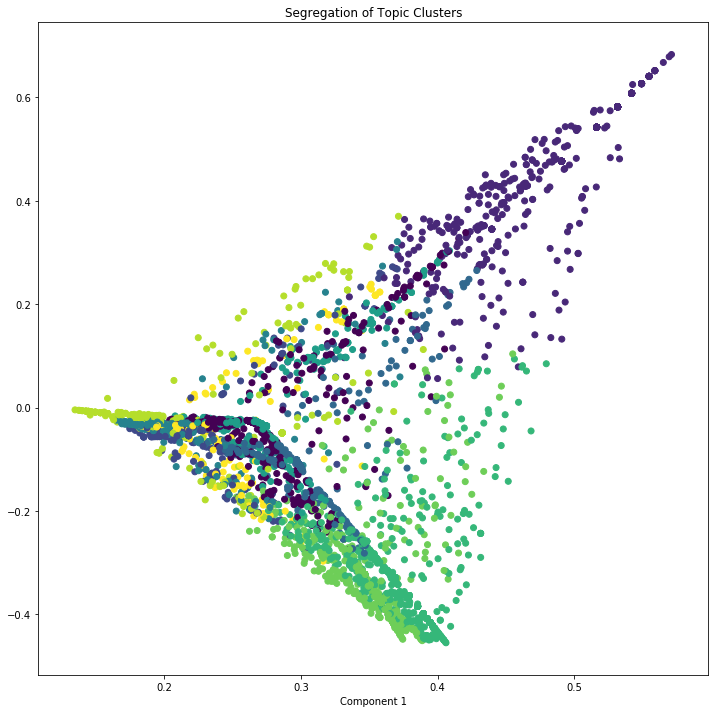

In [149]:
# 
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [ ]:
Stop

# 6 Abandoned tracks
- Most of them are constaint by computational resource

## 6.1 PCA to TF-IDF， then Kmeans
- not good, it's too slow

In [ ]:
import scipy.sparse
my_matrix = scipy.sparse.csr_matrix(tfidf)
tfidf_mtx = my_matrix.A
print("tfidf_mtx.shape: ",tfidf_mtx.shape)


In [ ]:
import scipy.sparse
from sklearn.decomposition import SparsePCA

my_matrix = scipy.sparse.csr_matrix(tfidf)
my_array = my_matrix.A
pca = SparsePCA(n_components = 1000, random_state=1234).fit(tfidf_mtx) 
tfidf_pca = pca.transform(tfidf_mtx)


k = arg_k
kmeans_pca = KMeans(n_clusters = k, random_state = 0).fit(tfidf_pca)
label_pca = pd.DataFrame(kmeans_pca.labels_, columns=['label'])
result_pca = corpus_cl.join(label, how="inner",rsuffix='_cleaned')

### 6.2 Model2 - Kmeans: all sentences 
   - Hyper parameters: K=42
   - Input: TFIDF - matrix, unique sentence 300,000+ sentences
   - Filter: stop_words="english", min_df=2

In [ ]:
# all_corpus = " ".join(s_len)

In [ ]:
# # transform all sentence into feature space
# docs = s_len['text'][[1,100,2000,30000]]
# tokens = tfidf_vect.get_feature_names()

# def get_doc_tokens(doc):
# #     tokens=[token.strip() \
# #             for token in nltk.word_tokenize(doc.lower()) \
# #             if token.strip() not in stop_words and\
# #                token.strip() not in string.punctuation]
    
#     # you can add bigrams, collocations, or lemmatization here
    
#     # create token count dictionary
# #     token_count=nltk.FreqDist(tokens)
#     token_count={token:tokens.count(token) for token in set(tokens)} 
#     return token_count


# docs_tokens={idx:get_doc_tokens(doc) for idx,doc in enumerate(docs)}
# # print(docs_tokens)

In [ ]:
# # x_train = vectorizer.transform(s_len['text'][1:100000])
# dtm=pd.DataFrame.from_dict(docs_tokens, orient="index" )
# dtm=dtm.fillna(0)

# # convert dtm to numpy arrays
# tf=dtm.values

# # sum the value of each row
# doc_len=tf.sum(axis=1)
# # print(doc_len)

# # divide dtm matrix by the doc length matrix
# tf=np.divide(tf, doc_len[:,None])
# # print(tf)

# # get document freqent
# df=np.where(tf>0,1,0)

# # get idf
# idf=np.log(np.divide(len(docs),np.sum(df, axis=0)))+1

# smoothed_idf=np.log(np.divide(len(docs)+1, np.sum(df, axis=0)+1))+1


# smoothed_tf_idf=normalize(tf*smoothed_idf)

In [ ]:
# k=3
# kmeans = KMeans(n_clusters = k, random_state = 0).fit(smoothed_tf_idf)
# label = pd.DataFrame(kmeans.labels_, columns=['label'])
# # kmeans.labels_ 
# # labels = kmeans.predict(x_train).tolist()

# result = dup.join(label, how="inner").join(pd.DataFrame(corpus), how="inner",rsuffix='_cleaned')
# result

# 7 Other codes Toolkit
## 7.1 save the result into txt file

In [ ]:
# # saving into file
# for j in range(k):
#     MyFile = open('/content/gdrive/My Drive/temp_ans_' + str(k) + '_' +str(j) + '.txt','w')
#     for i in df[df['Result'] == j]['Paragraph'].tolist():
#          MyFile.write(i)
#          MyFile.write('\n\n\n')

# MyFile.close()
# print('Done')

## 7.2 Transform the scaping file into Excel

In [ ]:
path = "C:/Users/Administrator/Desktop/JD_results/JD_results/" 
files= os.listdir(path) 

k_begin = 52
k_end = 52

k_cend = k_end +1 # for iteration
T = pd.DataFrame(np.zeros(k_cend**2).reshape(k_cend,k_cend)).astype(str)
col_name =  ['N'+'='+str(x) for x in list(range(k_cend))]
# col_name

In [ ]:
# Save file.info into dataframe T
for k in range(k_begin, k_cend):
    f = path+"k="+str(k) # obtain file name of K=?
    docs = os.listdir(f) # obtain N txts' name under K
    col = 0
    for km in docs:
        doc =  open(f+'/'+km,"r", encoding = 'utf8') 
        T.iloc[k,col] = doc.read().split("\n\n\n")
        col += 1
    print("%s-Clustering"%k,"  ", "loaded N=%s cols"%col) # process

# Each rows = K ,  Each cols = N-clusters under K
# 4 row, 0 col:  is one of cluster in the K = 4 (Kmeans)


In [ ]:
# T.iloc[4,0]

In [ ]:
# Read the file from DataFrame T: unzip a cell of T into DataFrame AA
for k in range(k_begin, k_cend):
    col_n = 1 # each N under specific K-clusters.
    AA = pd.DataFrame(T.iloc[k,0])
    for km in range(k_cend):
        if len(T.iloc[k,km])>100:
            AA = pd.concat([AA, pd.DataFrame(T.iloc[k,km])], axis = 1)
            col_n+=1  # iterate for N in specific K-clusters.
    AA.columns = col_name[0:col_n] # named cols from N=0 to N=col_n
    Result = AA.drop(columns=['N=0']) # Drop first columns (which is duplicated)


## 7.3  Save into excel file of K-means result

In [ ]:
# # Save the excel file of K-means result
# def mkdir(path):
#     if not os.path.exists(path):
#         os.makedirs(path)   
#         print("--- Create a file ---")
#     else:
#         print("--- Existed file ---")
# file = path+'excel_result'
# mkdir(file)    



# writer=pd.ExcelWriter(file+'/'+'ALL-'+str(k_cend)+'.xlsx')

# for k in range(k_begin, k_cend):
#     col_n = 1
#     AA = pd.DataFrame(T.iloc[k,0]) # in order to concat in dataframe. The first column will be deleted
#     for km in range(k_cend):
#         if len(T.iloc[k,km])>100:
#             AA = pd.concat([AA, pd.DataFrame(T.iloc[k,km])], axis = 1)
#             col_n+=1  
#     AA.columns = col_name[0:col_n] # named cols
#     Result = AA.drop(columns=['N=0']) 
#     Result.to_excel(writer,sheet_name='class='+str(k)) # save sheets into one Excel
                    
# writer.save()